In [1]:
%matplotlib qt

In [2]:
import os
import pyxdf
import numpy as np
import mne
import matplotlib.pyplot as plt
import scipy
import json

### Settings

In [3]:
# Files
subject = 'P00J'
session = 1
task = 'P300_4x4_gface'
lslDir = os.path.join(os.path.expanduser('~'), 'Documents\CurrentStudy')

# LSL Stream
eeg_stream_type = 'EXG'
markers_stream_type = 'Marker'

# Experiment parameters
rest_duration = 5
task_duration = 5

# Events
# event_dict = {'rest': 0, 'MI/hands': 1}
event_dict = {'nontarget': 0, 'target': 1}
tmin = 0
tmax = 1

In [4]:
# Find files
xdf_files = []
hasSubject = subject!=''
hasSession = session!=''
hasTask = task!=''
for root, dir, files in os.walk(lslDir):
    for file in files:
        validFile = True
        if hasSubject:
            validFile = validFile and (('sub-'+subject) in file)
        if hasSession:
            validFile = validFile and (('ses-S' + str(session).zfill(3)) in file)
        if hasTask:
            validFile = validFile and (('task-' + task) in file)
        validFile = validFile and file.endswith('.xdf')
        if validFile:
            print(file)
            matchingFile = os.path.join(root, file)
            xdf_files.append(matchingFile)

if len(xdf_files) == 0:
    print('No files found')

sub-P00J_ses-S001_task-P300_4x4_gface_run-001_eeg.xdf
sub-P00J_ses-S001_task-P300_4x4_gface_run-002_eeg.xdf
sub-P00J_ses-S001_task-P300_4x4_gface_run-003_eeg.xdf
sub-P00J_ses-S001_task-P300_4x4_gface_run-004_eeg.xdf
sub-P00J_ses-S001_task-P300_4x4_gface_run-005_eeg.xdf


In [5]:
# Parse streams
eeg_stream, marker_stream = [], []

print('Parsing streams')
for xdf_file in xdf_files:
    streams, header = pyxdf.load_xdf(xdf_file)
    for i in range(len(streams)):
        if streams[i]['info']['type'][0] == eeg_stream_type:
            print("Found %s stream in %s" % (eeg_stream_type, os.path.basename(xdf_file)))
            eeg_stream.append(streams[i])
        elif streams[i]['info']['type'][0] == markers_stream_type:
            print("Found %s stream in %s" % (markers_stream_type, os.path.basename(xdf_file)))
            marker_stream.append(streams[i])
del streams, header

Parsing streams
Found EXG stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-001_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-001_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-002_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-002_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-003_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-003_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-004_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-004_eeg.xdf
Found EXG stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-005_eeg.xdf
Found Marker stream in sub-P00J_ses-S001_task-P300_4x4_gface_run-005_eeg.xdf


In [6]:
# Extract EEG data
print("Extracting EEG info")

ch_names = []
if eeg_stream[0]['info']['desc'][0]:
    print("EEG channel names found")
    for i in range(len(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'])):
        ch_names.append(eeg_stream[0]['info']['desc'][0]['channels'][0]['channel'][i]['label'][0])
else:
    print("EEG channel names not found... setting default")
    ch_names = ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
print('Channels: ', ch_names)

sfreq = float(eeg_stream[0]['info']['nominal_srate'][0])
print('Sampling frequency: ', sfreq)

# Create MNE info object
eeg_info = mne.create_info(ch_names, sfreq, ch_types='eeg')

Extracting EEG info
EEG channel names not found... setting default
Channels:  ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'F3', 'F4', 'T7', 'T8', 'P3', 'P4']
Sampling frequency:  125.0


In [7]:
montage = mne.channels.read_custom_montage('openbci_montage.elc')
# montage.plot()

In [8]:
# Get all EEG data
eeg_epoch_list = []

for n in range(len(eeg_stream)):
    # Create MNE Raw object
    eeg_data = np.transpose(eeg_stream[n]['time_series'])
    eeg_data = eeg_data / 1e6
    print(eeg_data.shape)
    eeg_raw = mne.io.RawArray(eeg_data, eeg_info)
    
    # Set montage
    eeg_raw.set_montage(montage)

    # Add annotations
    onset, duration, description = [], [], []
    current_target = -1
    current_flash = -1
    for i in range(len(marker_stream[n]['time_series'])):
        if 'MI' in task:
            if ('rest' in marker_stream[n]['time_series'][i][0]):
                onset.append(marker_stream[n]['time_stamps'][i] - eeg_stream[n]['time_stamps'][0])
                duration.append(rest_duration)
                description.append(marker_stream[n]['time_series'][i][0])
            elif ('task' in marker_stream[n]['time_series'][i][0]):
                onset.append(marker_stream[n]['time_stamps'][i] - eeg_stream[n]['time_stamps'][0])
                duration.append(task_duration)
                description.append(marker_stream[n]['time_series'][i][0].replace('task_', '').replace('-','/'))
        elif 'P300' in task:
            if('target' in marker_stream[n]['time_series'][i][0]):
                current_target = json.loads(marker_stream[n]['time_series'][i][0])['target']
            elif('flash' in marker_stream[n]['time_series'][i][0]):
                current_flash = json.loads(marker_stream[n]['time_series'][i][0])['flash']
                onset.append(marker_stream[n]['time_stamps'][i] - eeg_stream[n]['time_stamps'][0])
                duration.append(task_duration)
                description.append("target" if current_flash == current_target else "nontarget")

    annotations = mne.Annotations(onset, duration, description)
    eeg_raw = eeg_raw.set_annotations(annotations)
    eeg_raw = eeg_raw.notch_filter(60.)
    
    # Epoch data
    events, event_id = mne.events_from_annotations(eeg_raw, event_id=event_dict)
    eeg_epoch = mne.Epochs(eeg_raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, picks='eeg', preload=True, detrend=1)
    eeg_epoch_list.append(eeg_epoch)
    print(eeg_epoch)

(16, 21304)
Creating RawArray with float64 data, n_channels=16, n_times=21304
    Range : 0 ... 21303 =      0.000 ...   170.424 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 sec)



C:\Users\student\AppData\Local\Temp\ipykernel_9504\2445115664.py:38: RuntimeWarning: Limited 5 annotation(s) that were expanding outside the data range.
  eeg_raw = eeg_raw.set_annotations(annotations)


Used Annotations descriptions: ['nontarget', 'target']
Not setting metadata
Not setting metadata
800 matching events found
No baseline correction applied
0 projection items activated
Loading data for 800 events and 126 original time points ...
0 bad epochs dropped
<Epochs |  800 events (all good), 0 - 1 sec, baseline off, ~12.3 MB, data loaded,
 'nontarget': 750
 'target': 50>
(16, 21411)
Creating RawArray with float64 data, n_channels=16, n_times=21411
    Range : 0 ... 21410 =      0.000 ...   171.280 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)

C:\Users\student\AppData\Local\Temp\ipykernel_9504\2445115664.py:38: RuntimeWarning: Limited 5 annotation(s) that were expanding outside the data range.
  eeg_raw = eeg_raw.set_annotations(annotations)


0 bad epochs dropped
<Epochs |  800 events (all good), 0 - 1 sec, baseline off, ~12.3 MB, data loaded,
 'nontarget': 750
 'target': 50>
(16, 20686)
Creating RawArray with float64 data, n_channels=16, n_times=20686
    Range : 0 ... 20685 =      0.000 ...   165.480 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 sec)

Used Annotations descriptions: ['nontarget', 'target']
Not setting metadata
Not setting metadata
800 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8

C:\Users\student\AppData\Local\Temp\ipykernel_9504\2445115664.py:38: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  eeg_raw = eeg_raw.set_annotations(annotations)


0 bad epochs dropped
<Epochs |  800 events (all good), 0 - 1 sec, baseline off, ~12.3 MB, data loaded,
 'nontarget': 750
 'target': 50>
(16, 20309)
Creating RawArray with float64 data, n_channels=16, n_times=20309
    Range : 0 ... 20308 =      0.000 ...   162.464 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 sec)

Used Annotations descriptions: ['nontarget', 'target']
Not setting metadata
Not setting metadata
800 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8

C:\Users\student\AppData\Local\Temp\ipykernel_9504\2445115664.py:38: RuntimeWarning: Limited 11 annotation(s) that were expanding outside the data range.
  eeg_raw = eeg_raw.set_annotations(annotations)


0 bad epochs dropped
<Epochs |  800 events (all good), 0 - 1 sec, baseline off, ~12.3 MB, data loaded,
 'nontarget': 750
 'target': 50>


In [9]:
# concatenate all epochs
eeg_epochs = mne.concatenate_epochs(eeg_epoch_list)
eeg_epochs

Not setting metadata
Not setting metadata
4000 matching events found
No baseline correction applied
0 bad epochs dropped


Number of events,4000
Events,nontarget: 3750target: 250
Time range,0.000 – 1.000 sec
Baseline,off


In [10]:
# Re-reference data
eeg_epochs = eeg_epochs.set_eeg_reference ('average', projection=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [11]:
# Filter data
l_freq = 1.
h_freq = 40.
eeg_filt = eeg_epochs.copy()
eeg_filt = eeg_filt.filter(l_freq, h_freq, n_jobs=-1)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 413 samples (3.304 sec)



C:\Users\student\AppData\Local\Temp\ipykernel_9504\568159571.py:5: RuntimeWarning: filter_length (413) is longer than the signal (126), distortion is likely. Reduce filter length or filter a longer signal.
  eeg_filt = eeg_filt.filter(l_freq, h_freq, n_jobs=-1)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 4156 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 50236 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done 64000 out of 64000 | elapsed:   11.8s finished


In [12]:
# plot eeg data
fig = eeg_epochs.plot(title='Raw Data', n_channels=len(ch_names), show=True, n_epochs=1)

Using matplotlib as 2D backend.


In [13]:
evoked_target = eeg_epochs['target'].average()
evoked_nontarget = eeg_epochs['nontarget'].average()

evokeds_list = [evoked_nontarget, evoked_target]
conds = ('nontarget', 'target')
evks = dict(zip(conds, evokeds_list))

Dropped 0 epochs: 
Channels marked as bad: none


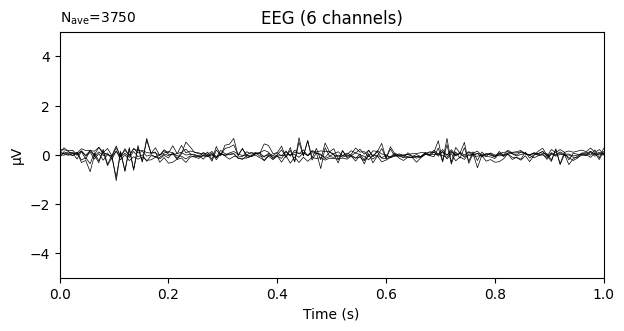

In [14]:
plt.close('all')

# picks=['P7', 'P8']
# picks=['P3', 'P4']
# picks=['O1', 'O2']
picks=['P7', 'P8', 'P3', 'P4', 'O1', 'O2']
# picks='eeg'
ylim = dict(eeg=[-5, 5])
evoked_target.plot(picks=picks, ylim=ylim)
evoked_nontarget.plot(picks=picks, ylim=ylim)

In [15]:
plt.close('all')
mne.viz.plot_compare_evokeds(evks, picks=picks, colors=dict(nontarget=0, target=1))

combining channels using "gfp"
combining channels using "gfp"


[<Figure size 800x600 with 1 Axes>]

In [16]:
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from mne.decoding import Vectorizer
# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

In [17]:
clfs = OrderedDict()
clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['Xdawn + RegLDA'] = make_pipeline(Xdawn(2, classes=[1]), Vectorizer(), LDA(shrinkage='auto', solver='eigen'))

clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())


clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(), MDM())

# format data
# epochs.pick_types(eeg=True)
epochs = eeg_epochs.copy()

X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    res = cross_val_score(clfs[m], X, y==1, scoring='roc_auc', cv=cv, n_jobs=-1)
    auc.extend(res)
    methods.extend([m]*len(res))

results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.2, 0.85)
sns.despine()

C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\pipeline.py", line 348, in _fit
    X, fitted_transformer =

C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\student\anaconda3\envs\mindset\lib\site-packages\pyriemann\classification.py", line 114, in fit
    

In [ ]:
# plot eeg data
fig = eeg_filt.plot(title='Filtered Data', n_channels=len(ch_names), show=True, n_epochs=1)

In [ ]:
fig = eeg_epochs.plot_psd()

In [ ]:
fig = eeg_filt.plot_psd()

In [ ]:
plt.close('all')

In [ ]:
# print(eeg_epochs)

fig = eeg_epochs['rest'].plot_psd()
fig = eeg_epochs['MI/hands'].plot_psd()

In [ ]:
rest_data = eeg_epochs['rest'].get_data()
MI_data = eeg_epochs['MI/hands'].get_data()
f, Pxx_den_rest = scipy.signal.welch(np.mean(rest_data, 0), fs=125.)
f, Pxx_den_MI = scipy.signal.welch(np.mean(MI_data, 0), fs=125.)


channel = 3
plt.title('Welch PSD for channel: %s' % ch_names[channel])
plt.semilogy(f, Pxx_den_rest[channel,:])
plt.semilogy(f, Pxx_den_MI[channel,:])
plt.xlim([0, 30])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.legend(['rest', 'MI/hands'])
plt.show()